# Processing Grinberg's samples
- preprocessing
- clustering
- measuring different phases
- panda: format, save, plotting

In [78]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [80]:
import rasterio
import math
import scipy.ndimage as ndi
from scipy import stats
from skimage import morphology, exposure, color
from skimage.filters import threshold_isodata
from skimage.segmentation import slic
from skimage.measure import regionprops,label
from sklearn import cluster
import time

In [66]:
#channel 3 (the TBR1 marker)
#channel 4 is the NeuN marker channel
import rasterio
st = '/Users/dani/Dropbox/UCSF/rana/P2593_ROI_1.jp2'

f = rasterio.open(st)
data = f.read()
print('Input shape:',data.shape)

Input shape: (5, 2048, 2048)


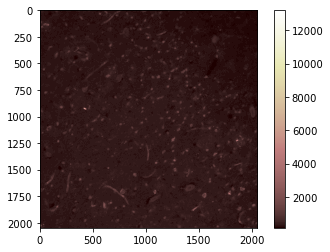

In [5]:
plt.imshow(data[2,:,:],cmap='pink')
plt.colorbar()

In [18]:
def imshowcmp(before,after,str1='before',str2='after',cmap='viridis'):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    p = ax[0].imshow(before,cmap=cmap)
    ax[0].set_title(str1)
    f.colorbar(p, ax=ax[0],orientation="horizontal")
    p = ax[1].imshow(after,cmap=cmap)
    ax[1].set_title(str2)    
    f.colorbar(p, ax=ax[1],orientation="horizontal")

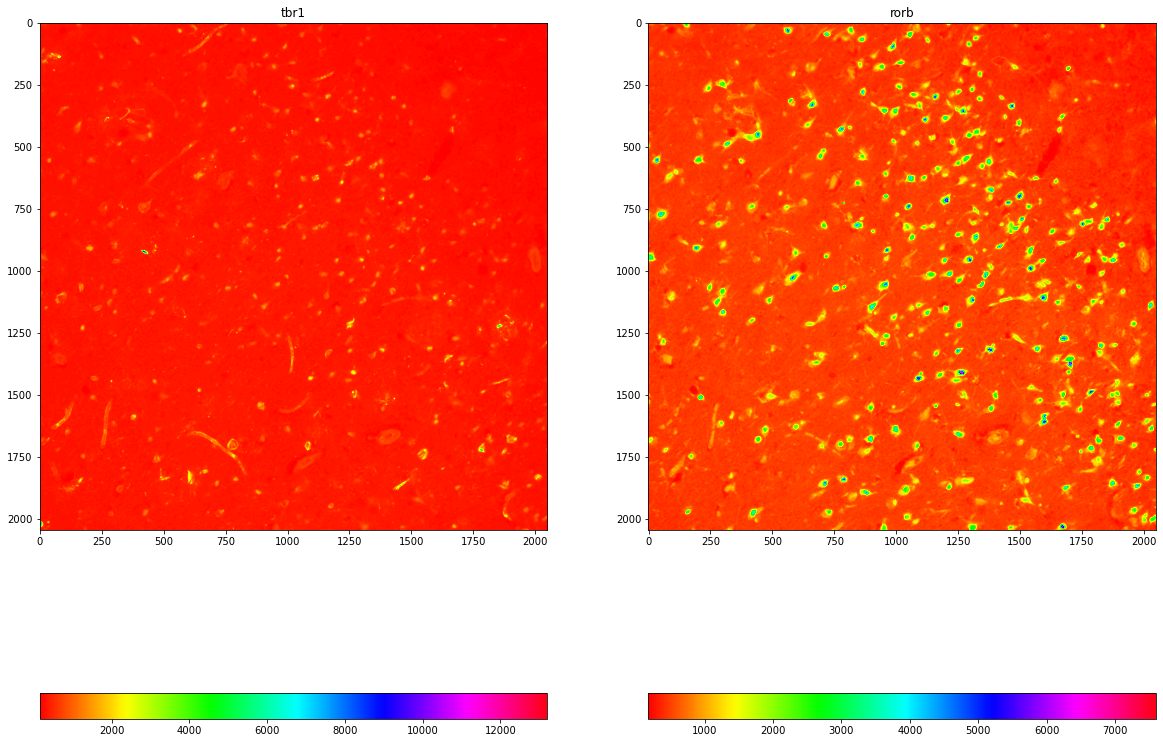

In [63]:
tbr1 = data[2,:,:]
rorb = data[3,:,:]
imshowcmp(tbr1,rorb,'tbr1','rorb','hsv')

## Pre-processing

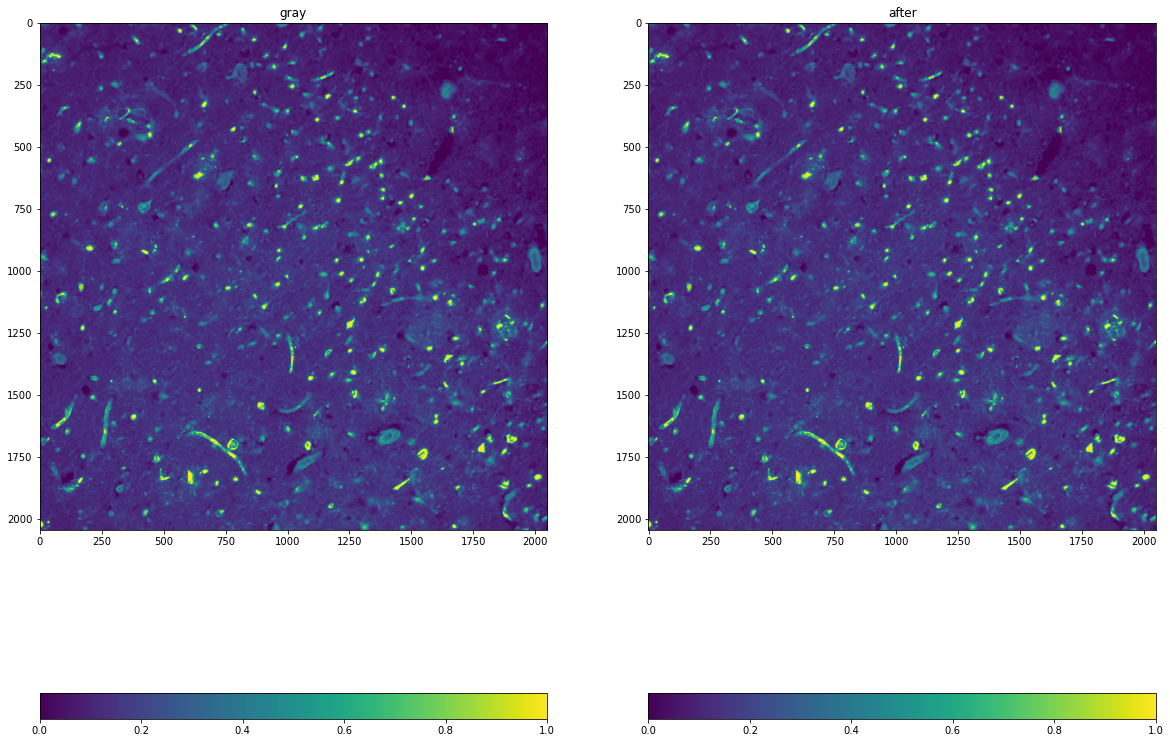

In [64]:
def enhanceSlice(img):
    vmin, vmax = stats.scoreatpercentile(img, (1, 99.5))
    newSlice = np.clip(img, vmin, vmax)
    newSlice = (newSlice - vmin) / (vmax - vmin)
    newSlice = ndi.median_filter(newSlice,footprint=morphology.disk(radius=3))
    return newSlice

imshowcmp(enhanceSlice(tbr1),enhanceSlice(neun),'gray')

In [9]:
def seeHistSlice(aSlice):
        '''See the histogram of a particular slice after its masking, followed by enhancement'''
        hist, hist_centers = exposure.histogram(aSlice)
        fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

        ax[0].imshow(aSlice, cmap=plt.cm.gray, vmin=np.min(aSlice), vmax=np.max(aSlice))
        ax[0].set_title('Slice at the center of the stack')
        ax[0].axis('off')

        ax[1].plot(hist_centers, hist, lw=2)
        ax[1].set_title('Histogram of grey values')
        ax[1].grid()

        plt.tight_layout()

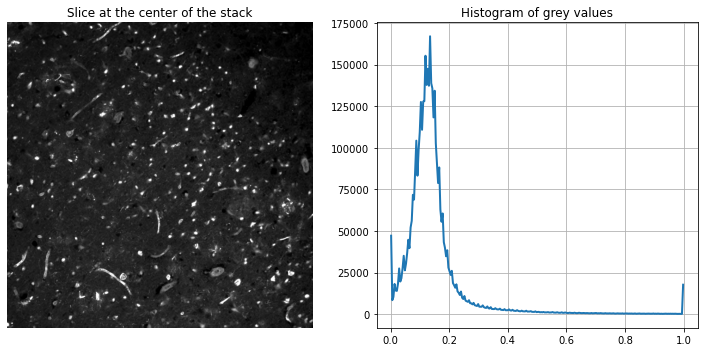

In [10]:
seeHistSlice(enhanceSlice(tbr1))

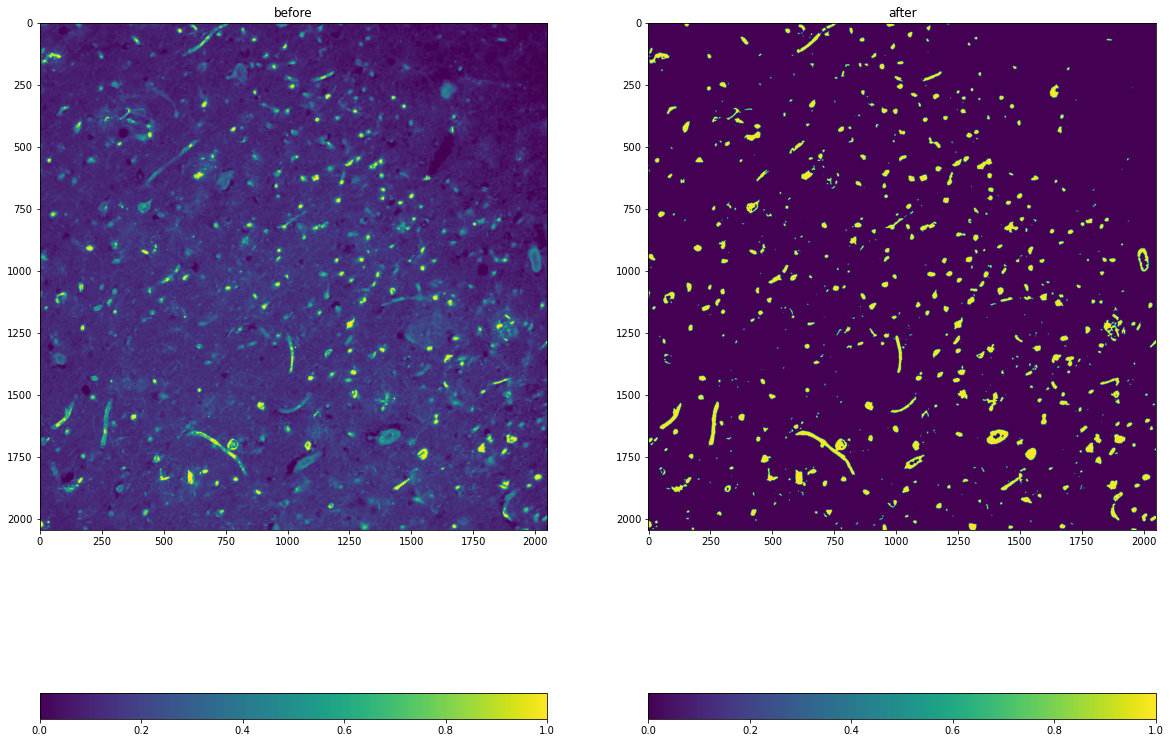

In [11]:
# TODO: generalize for n images
a = enhanceSlice(tbr1)

imshowcmp(a,a>threshold_isodata(a))

## Superpixels

In [12]:
x, y = a.shape
np_coreSampFlat = a.reshape((-1,1))
np_coreSampFlat.shape

(4194304, 1)

In [13]:
len(np.unique(np_coreSampFlat))

1092

### Superpixel with kmeans

In [55]:

start_time = time.time()

numberOfClusters = 16 #empirical - test others within optimizer 
kmeans_cluster = cluster.KMeans(n_clusters=numberOfClusters)
kmeans_cluster.fit(np_coreSampFlat)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 115.71291518211365 seconds


In [56]:
img_labels = cluster_centers[cluster_labels].reshape(x, y)

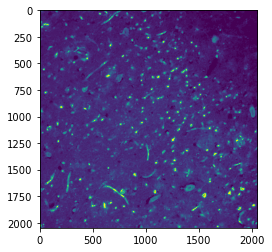

In [57]:
plt.imshow(img_labels) #cmp with np_coreSample

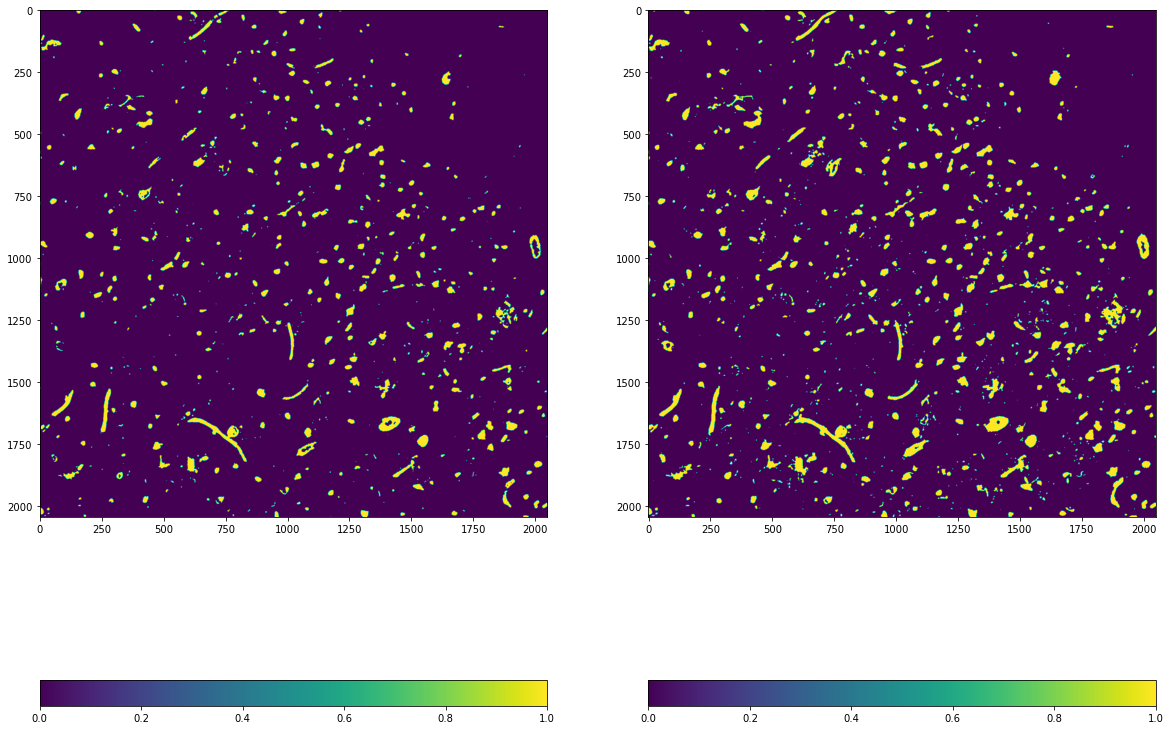

In [58]:
imshowcmp(a>threshold_isodata(a),img_labels>threshold_isodata(img_labels))

## Segment phases
- 

In [4]:
# TODO: show individual phases, apply morphological filters for cleaning

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


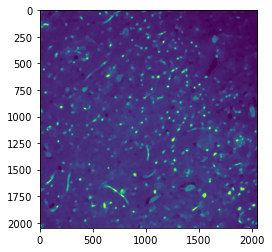

In [14]:

aSlice = a
w,h = aSlice.shape
nSegms = w*h//900 #The (approximate) number of labels in the segmented output image.
segments = slic(aSlice.astype(np.double), n_segments=nSegms, compactness=0.1, enforce_connectivity=False, sigma=5, max_iter=200, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, aSlice, kind='avg')
plt.imshow(output)

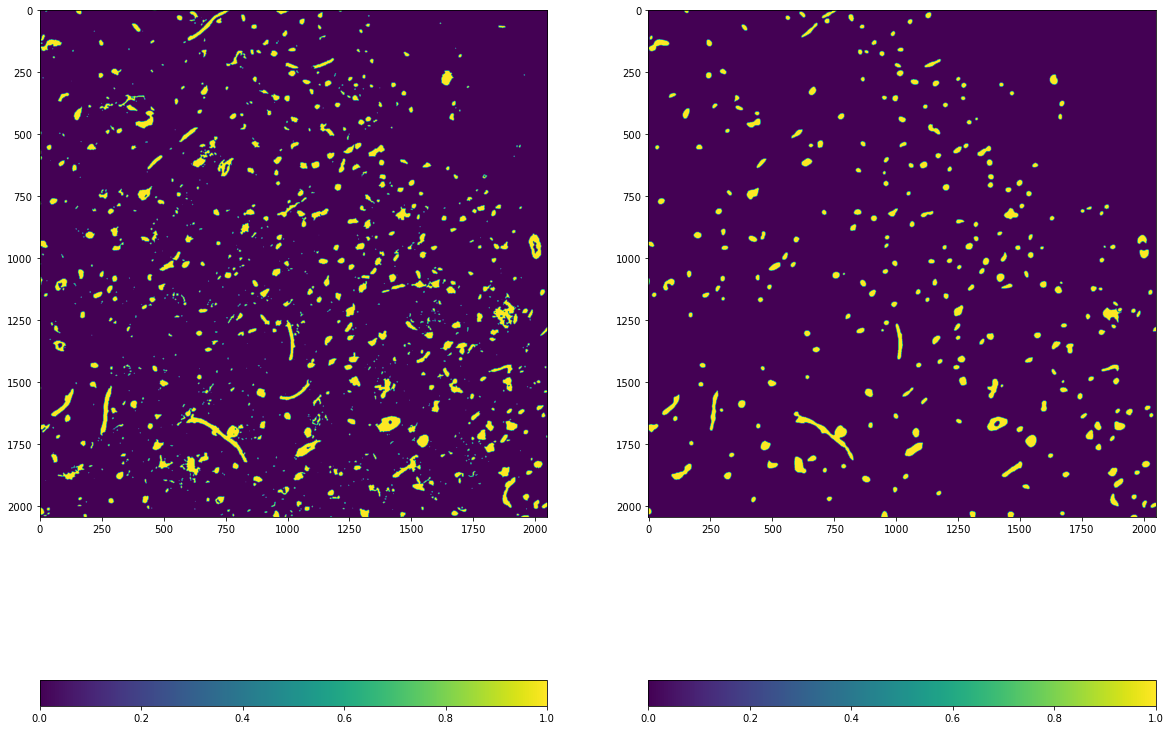

In [60]:
imshowcmp(img_labels>threshold_isodata(img_labels),output>threshold_isodata(output))

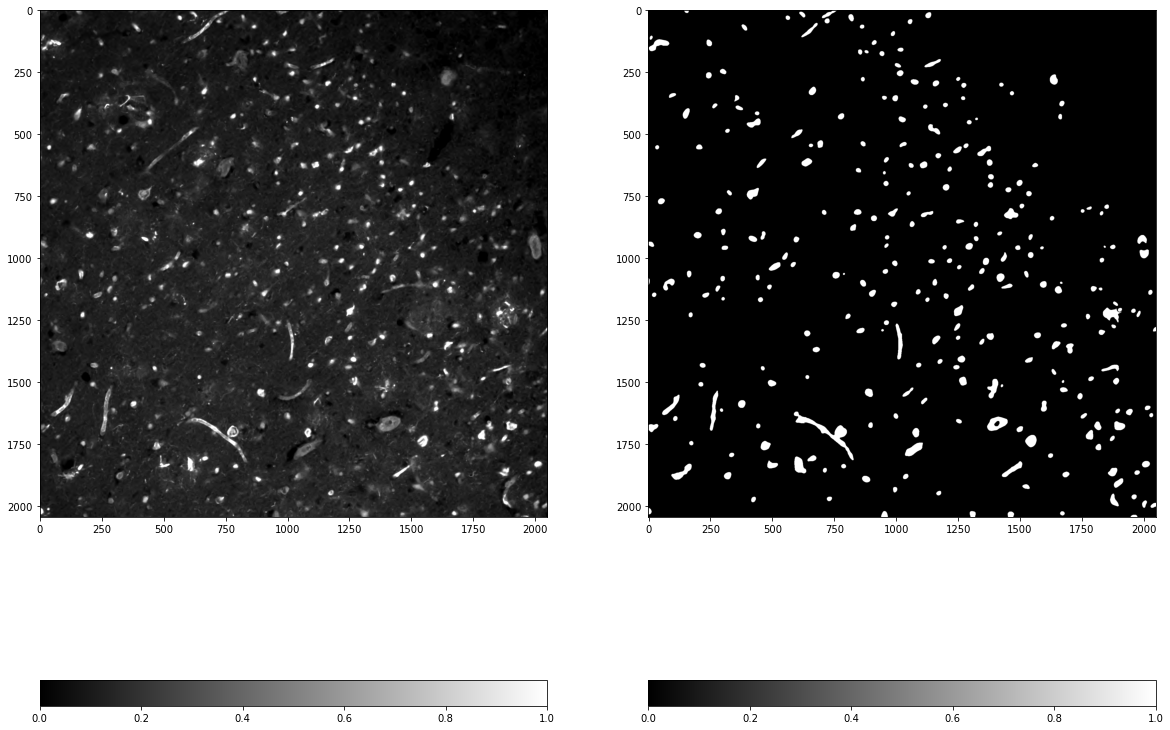

In [63]:
imshowcmp(enhanceSlice(tbr1),output>threshold_isodata(output),'gray')

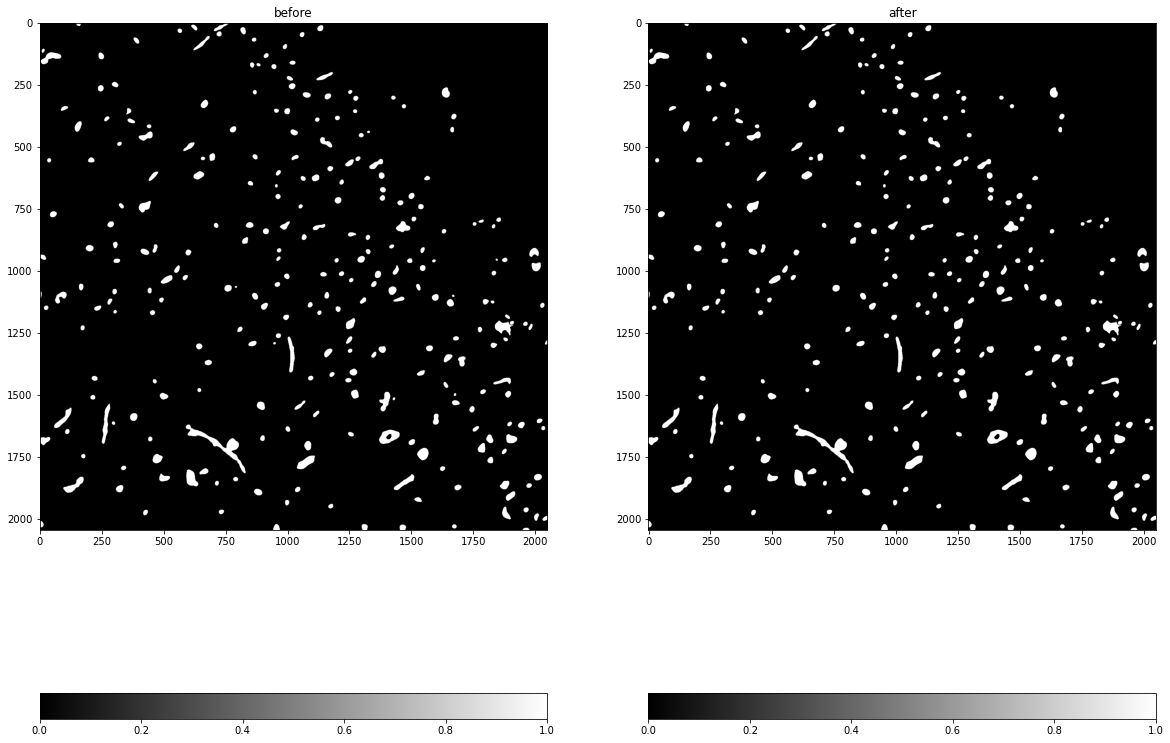

In [20]:
image = output>threshold_isodata(output)
image2 = morphology.remove_small_objects(image,min_size=100) # if using label for area, then remove this
imshowcmp(image,image2,cmap='gray')

## Measurements

In [21]:
import math
from skimage.measure import regionprops, label
labeled = label(image2)
regions = regionprops(labeled)

In [40]:
pixelSize = 1 #check this with Tonya/Rana
larea=[]
lcircularity=[]
labels = np.arange(np.max(labeled) + 1)
for region in regions:
    area = float(region.area * pixelSize**2)
    circularity = 4*math.pi*(region.area/region.perimeter**2)
    if not (100 <= area <= 10000
        and circularity > 0.5):
        labels[region.label] = 0
    else:
        larea.append(area)
        lcircularity.append(circularity)

finalMask = labels[labeled] >0       
        
#labels[np.isin(labels, labels_to_remove)] = 0        


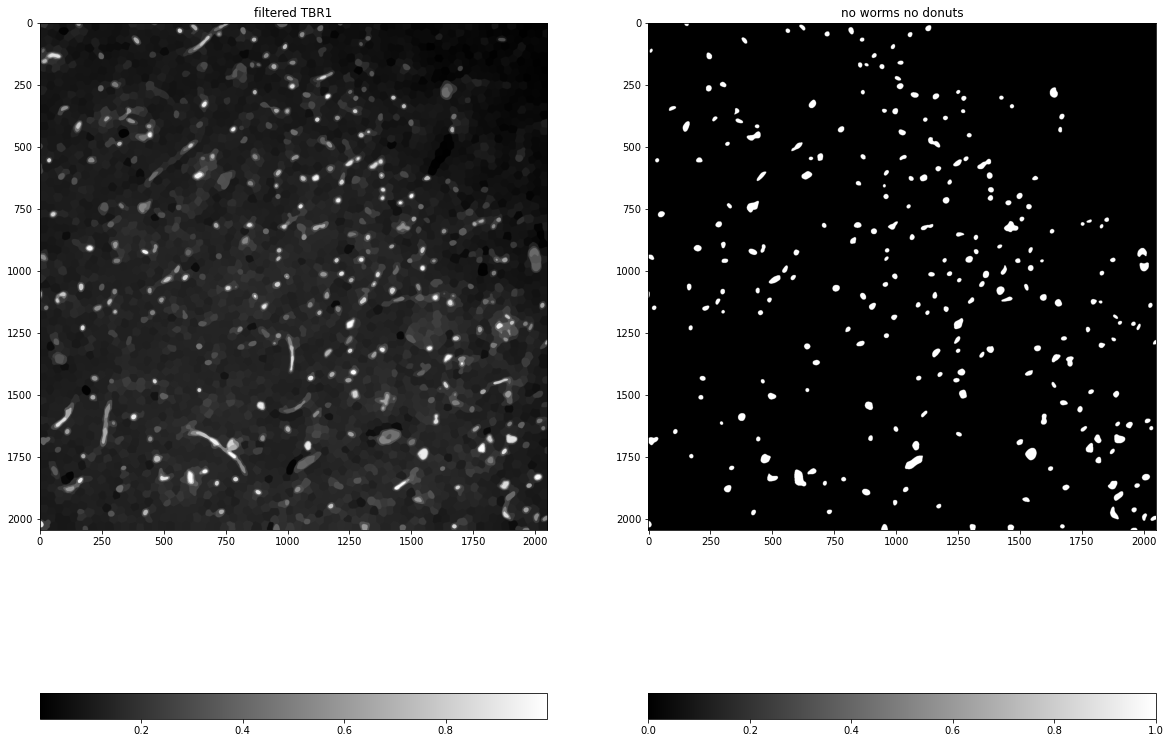

In [39]:
imshowcmp(output,finalMask,'filtered TBR1','no worms no donuts','gray')




In [46]:
import pandas as pd
sampleMetr = pd.DataFrame({
                        'area':larea,
                        'circularity':lcircularity
                        })

To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c2bb210>,
      dtype=object)

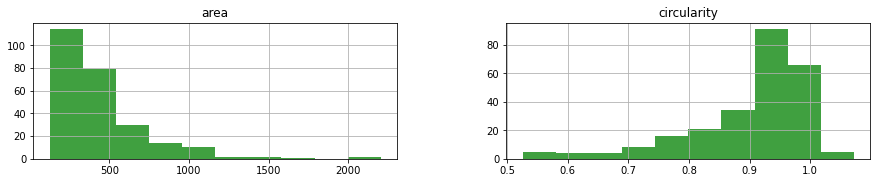

In [58]:
fig = plt.figure(figsize = (15,2.5))
ax = fig.gca()
sampleMetr.hist(bins=10,density=False,facecolor='g', alpha=0.75,ax = ax)


#ongoing
from skimage.measure import regionprops, label
labeled = label(image)
regions = regionprops(labeled)
area = []
centroid = []
for p in regions:
    area.append(p.area)
    centroid.append(p.centroid) # can use for scatter plot 
nobj = len(area)

In [101]:
class FindNeurons:

    def __init__(self,inputs,outputs): 
        '''Input and output paths '''
        self.inputp = inputs #path
        self.outputp = outputs #path
        f = rasterio.open(inputs)
        data = f.read()
        self.tbr1 = data[2,:,:]
        self.rorb = data[3,:,:]

    def seeHistSlice(self,aSlice):
        '''See the histogram of a 2D image'''
        hist, hist_centers = exposure.histogram(aSlice)
        fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
        ax[0].imshow(aSlice, cmap=plt.cm.gray, vmin=np.min(aSlice), vmax=np.max(aSlice))
        ax[0].set_title('Slice at the center of the stack')
        ax[0].axis('off')
        ax[1].plot(hist_centers, hist, lw=2)
        ax[1].set_title('Histogram of grey values')
        ax[1].grid()
        plt.tight_layout()
        
    def imshowcmp(self,before,after,str1='before',str2='after',cmap='viridis'):
        '''Show 2 images side by side'''
        f, ax = plt.subplots(1, 2, figsize=(20, 20))
        p = ax[0].imshow(before,cmap=cmap)
        ax[0].set_title(str1)
        f.colorbar(p, ax=ax[0],orientation="horizontal")
        p = ax[1].imshow(after,cmap=cmap)
        ax[1].set_title(str2)    
        f.colorbar(p, ax=ax[1],orientation="horizontal")

    def enhanceSlice(self,img):
        '''Enhance contrast and filter input'''
        vmin, vmax = stats.scoreatpercentile(img, (1, 99.5))
        newSlice = np.clip(img, vmin, vmax)
        newSlice = (newSlice - vmin) / (vmax - vmin)
        newSlice = ndi.median_filter(newSlice,footprint=morphology.disk(radius=3))
        return newSlice

    def imkmeans(self,img,k=16):
        '''Transform gray levels from input using k-means'''
        x, y = img.shape
        np_coreSampFlat = img.reshape((-1,1))
        numberOfClusters = k #empirical - test others within optimizer 
        kmeans_cluster = cluster.KMeans(n_clusters=numberOfClusters)
        kmeans_cluster.fit(np_coreSampFlat)
        cluster_centers = kmeans_cluster.cluster_centers_
        cluster_labels = kmeans_cluster.labels_
        img_labels = cluster_centers[cluster_labels].reshape(x, y)
        return img_labels

    def imslic(self,img):
        '''Transform gray levels from input using SLIC'''
        aSlice = img
        w,h = aSlice.shape
        nSegms = w*h//900 #The (approximate) number of labels in the segmented output image.
        segments = slic(aSlice.astype(np.double), n_segments=nSegms, 
                        compactness=0.1, enforce_connectivity=False, 
                        sigma=5, max_iter=200, multichannel=False) #higher compact = more weight space, more square
        output = color.label2rgb(segments, aSlice, kind='avg')
        output = output>threshold_isodata(output)
        return output

    def measurements(self,img):
        '''Extract area and circularity from binary input'''
        labeled = label(img)
        regions = regionprops(labeled)
        pixelSize = 1 #check this with Tonya/Rana
        larea=[]
        lcircularity=[]
        labels = np.arange(np.max(labeled) + 1)
        for region in regions:
            area = float(region.area * pixelSize**2)
            circularity = 4*math.pi*(region.area/region.perimeter**2)
            if not (100 <= area <= 10000
                and circularity > 0.5):
                labels[region.label] = 0
            else:
                larea.append(area)
                lcircularity.append(circularity)
        finalMask = labels[labeled] >0       
        sampleMetr = pd.DataFrame({
                            'area':larea,
                            'circularity':lcircularity
                            })
        return sampleMetr
        
    def histMeasurements(self,sampleMetr,mybin=10):
        '''Show histogram of area and circularity'''
        fig = plt.figure(figsize = (15,2.5))
        ax = fig.gca()
        sampleMetr.hist(bins=mybin,density=False,facecolor='g', alpha=0.75,ax = ax)

In [103]:
inputs = '/Users/dani/Dropbox/UCSF/rana/P2593_ROI_1.jp2'
outputs = '/Users/dani/Dropbox/UCSF/rana/outputs/'

f = FindNeurons(inputs,outputs)

Dataset has no geotransform set. The identity matrix may be returned.


In [96]:
start_time = time.time()

img = f.imslic(f.enhanceSlice( f.tbr1 ))

duration = time.time() - start_time
print(f"Duration {duration} seconds")

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


Duration 131.9924910068512 seconds


In [97]:
df = f.measurements(img)

To output multiple subplots, the figure containing the passed axes is being cleared


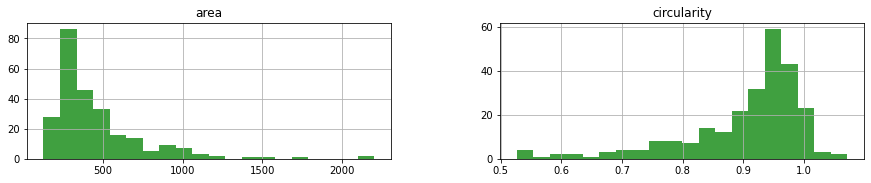

In [105]:
f.histMeasurements(df,mybin=20)